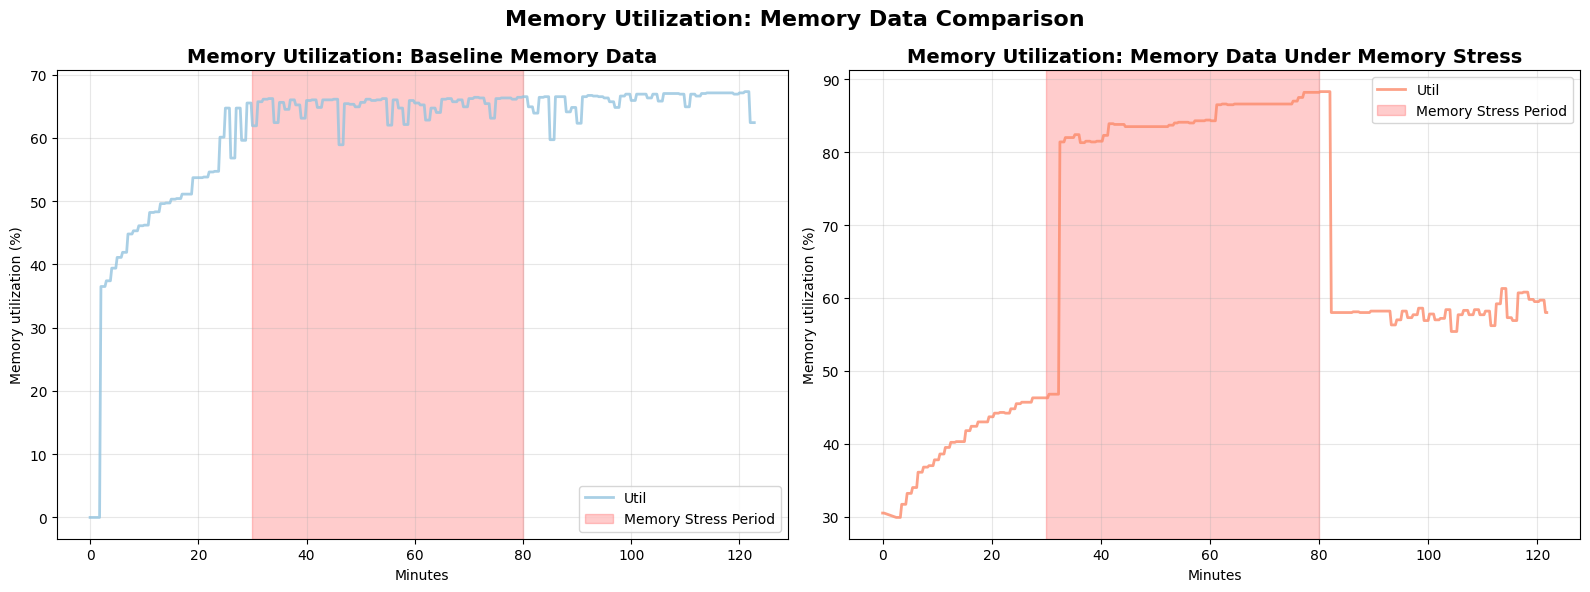

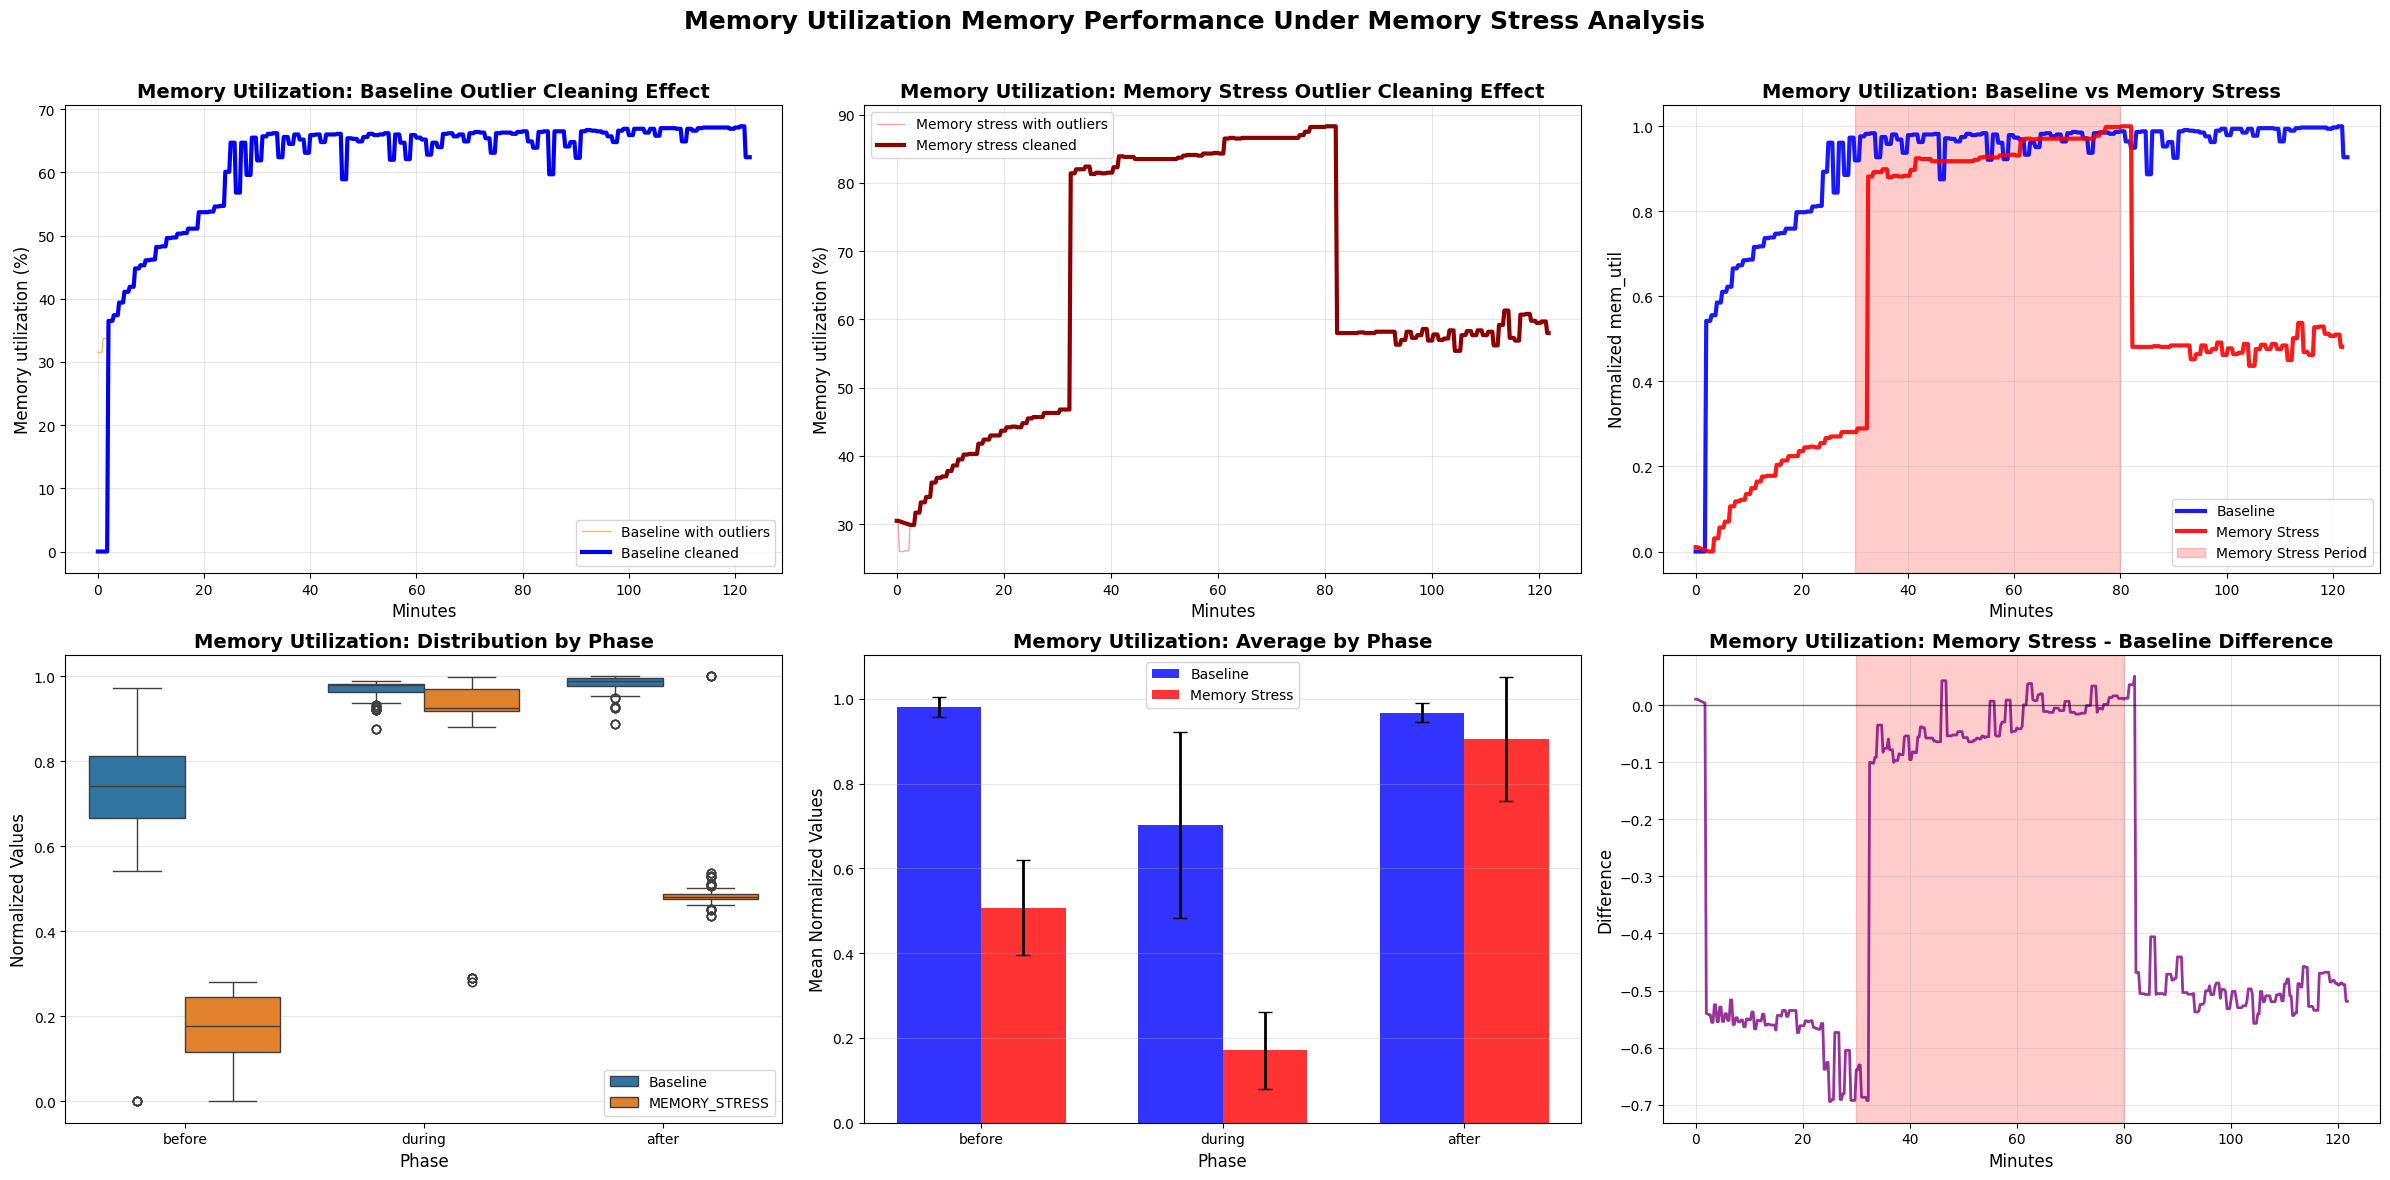


MEMORY UTILIZATION MEMORY - MEMORY STRESS ANALYSIS RESULTS

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9813  0.0230  0.8871  1.0000
before  0.7030  0.2191  0.0000  0.9733
during  0.9678  0.0229  0.8752  0.9881

MEMORY STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5074  0.1126  0.4366  1.0000
before  0.1704  0.0912  0.0000  0.2808
during  0.9054  0.1457  0.2808  0.9983

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 24.58, p=  0.0000 SIGNIFICANT
  DURING  : t=  6.00, p=  0.0000 SIGNIFICANT
  AFTER   : t= 53.88, p=  0.0000 SIGNIFICANT

MEMORY STRESS IMPACT ON MEMORY PERFORMANCE:
  BEFORE  :  -75.75% DECREASE
  DURING  :   -6.45% DECREASE
  AFTER   :  -48.29% DECREASE


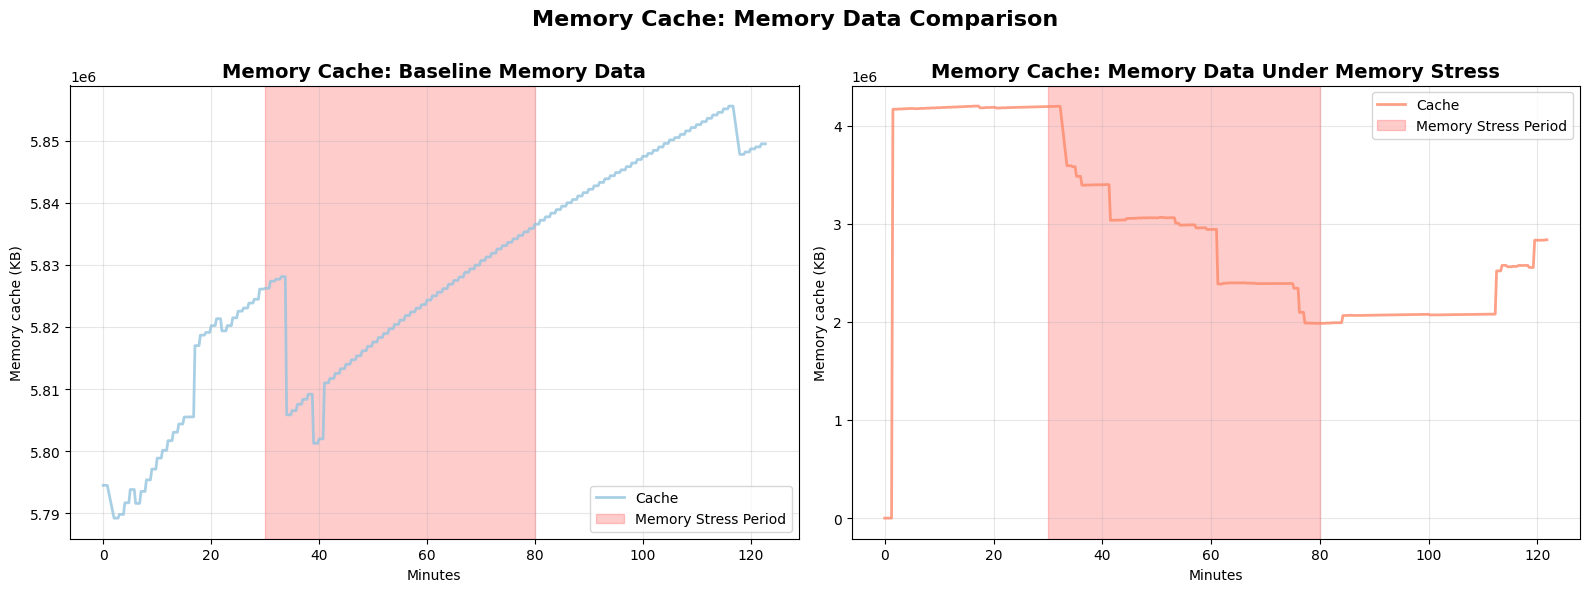

CACHE ANALYSIS FOR Memory Cache

CACHE ANALYSIS RESULTS

BASELINE CACHE STATISTICS (KB):
             mean      std        min        max  count
phase                                                  
after   5846739.0   5294.0  5836532.0  5855536.0    171
before  5807500.0  12920.0  5789228.0  5826088.0    120
during  5821813.0   9308.0  5801264.0  5836532.0    201

MEMORY STRESS CACHE STATISTICS (KB):
             mean       std        min        max  count
phase                                                   
after   2191331.0  248000.0  1984832.0  2836012.0    167
before  3973982.0  915551.0        0.0  4198060.0    120
during  2895609.0  548648.0  1984412.0  4195976.0    201

STATISTICAL SIGNIFICANCE:
  BEFORE  : t= 21.94, p=  0.0000 SIGNIFICANT
  DURING  : t= 75.60, p=  0.0000 SIGNIFICANT
  AFTER   : t=192.71, p=  0.0000 SIGNIFICANT

ABSOLUTE CACHE IMPACT:
  BEFORE  : -1833518 KB (-31.6%) DECREASE
  DURING  : -2926203 KB (-50.3%) DECREASE
  AFTER   : -3655408 KB (-62.5%) DECRE

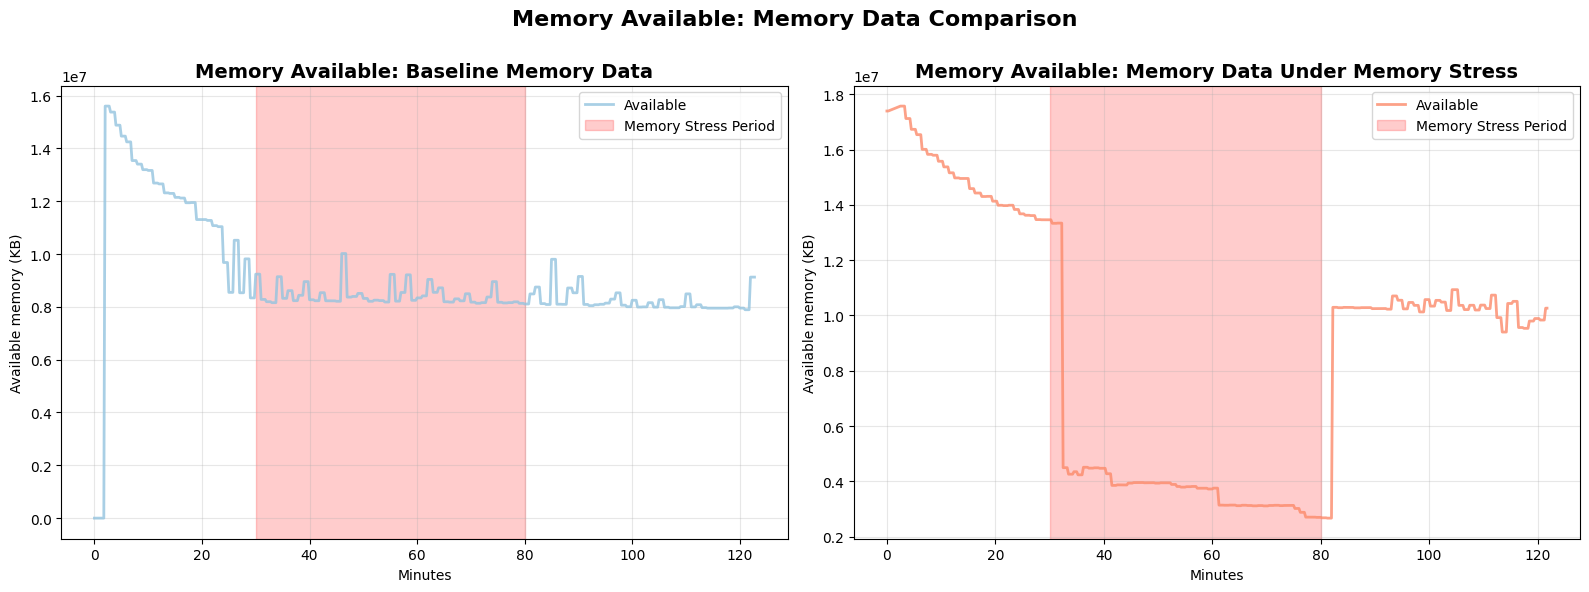

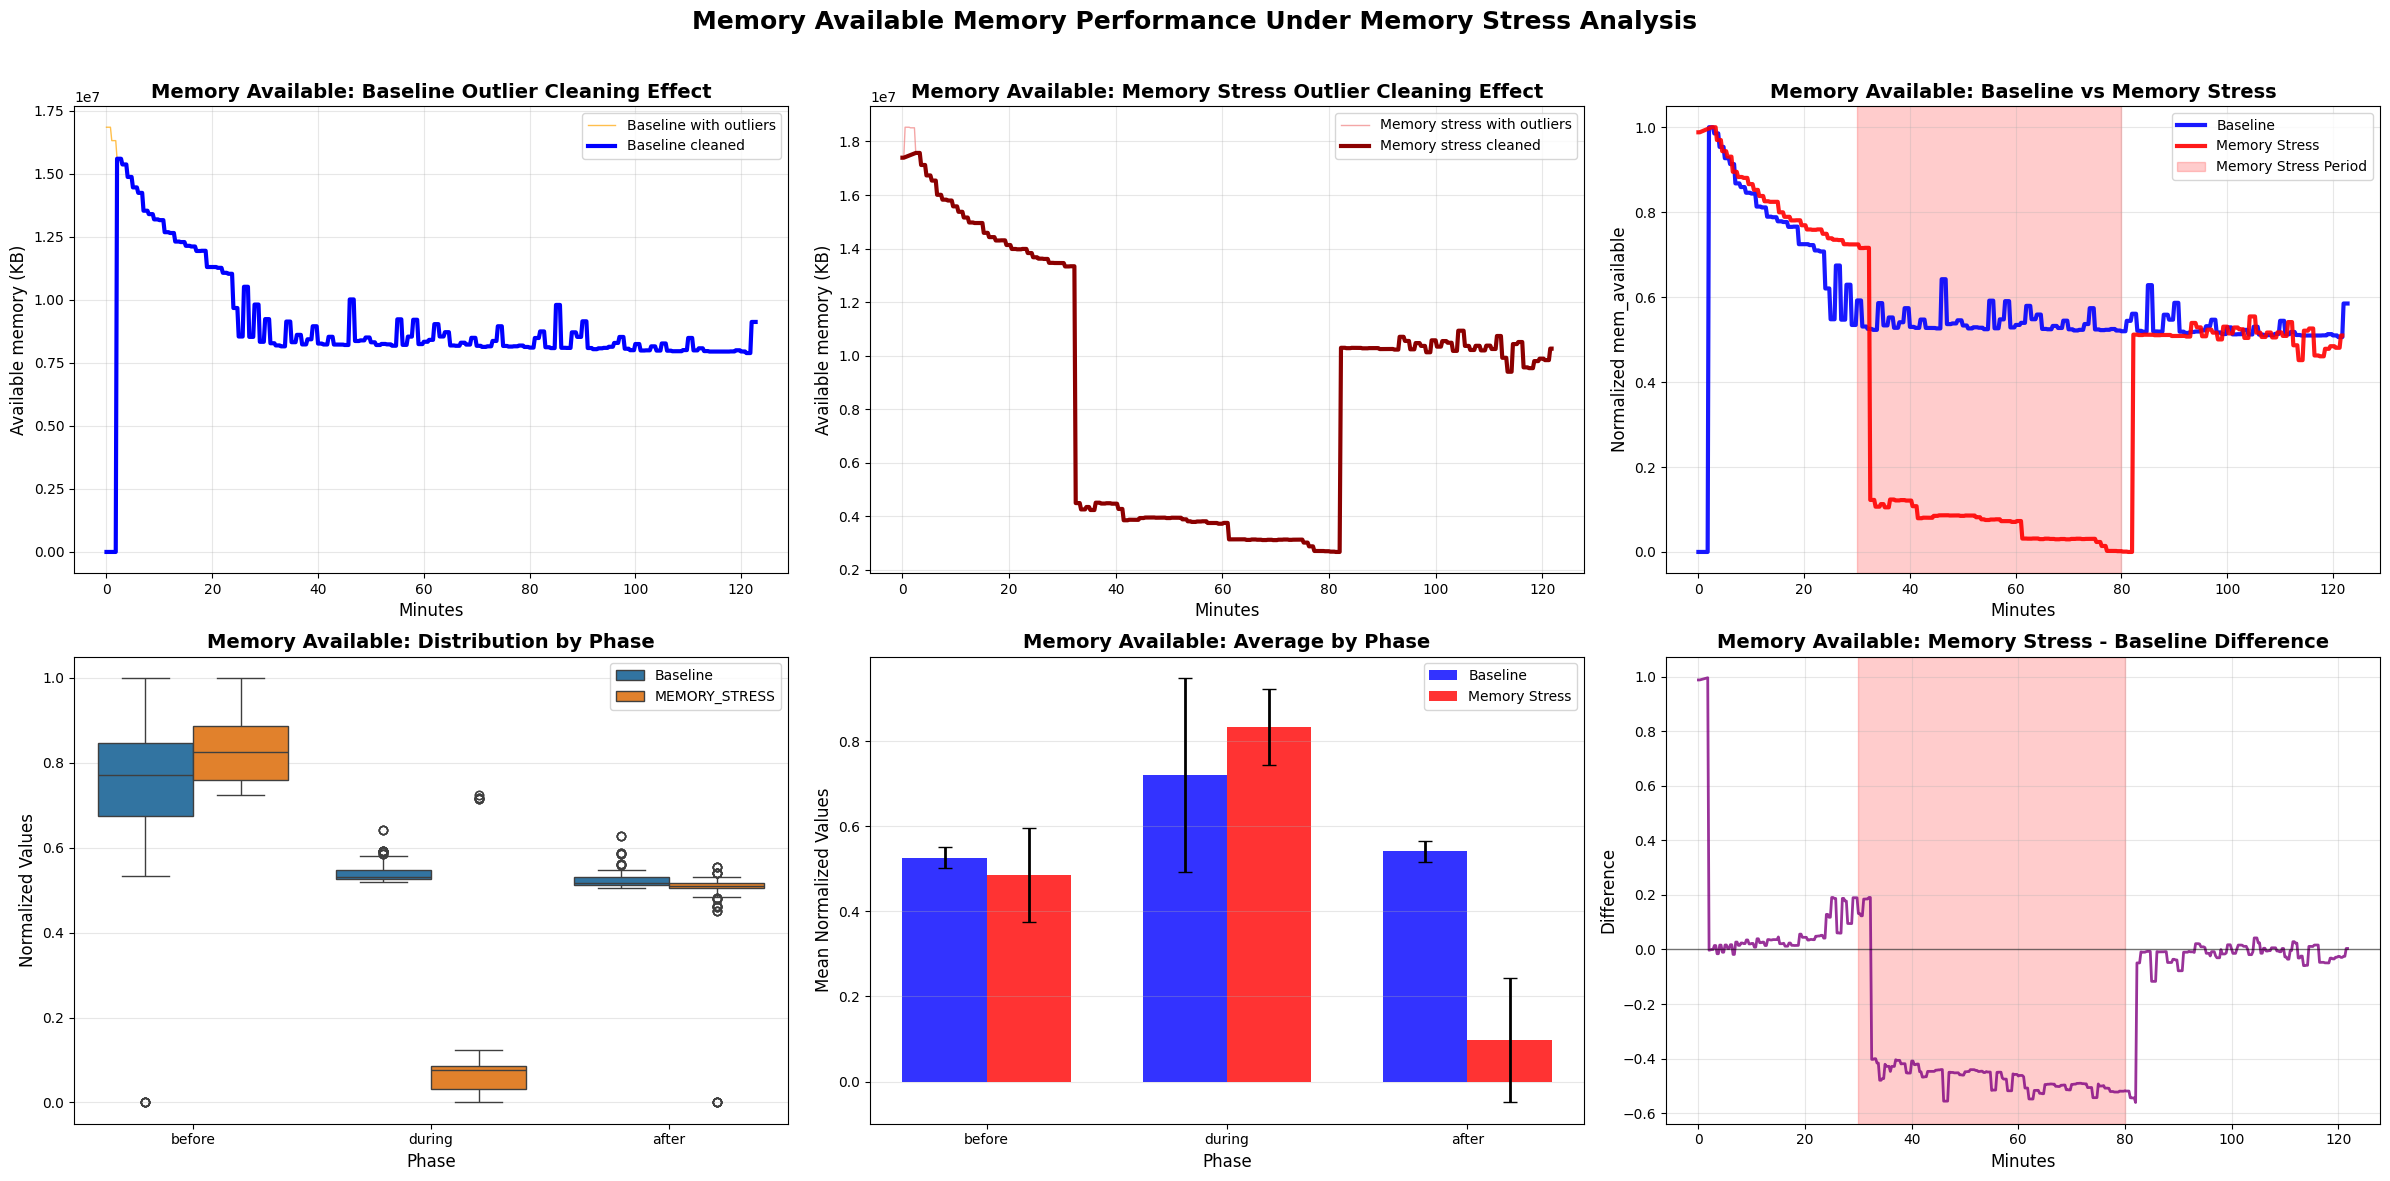


MEMORY AVAILABLE MEMORY - MEMORY STRESS ANALYSIS RESULTS

BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5265  0.0249  0.5058  0.6282
before  0.7209  0.2279  0.0000  1.0000
during  0.5412  0.0248  0.5197  0.6422

MEMORY STRESS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.4848  0.1109  0.0000  0.5545
before  0.8324  0.0892  0.7241  1.0000
during  0.0974  0.1465  0.0018  0.7241

STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -4.99, p=  0.0000 SIGNIFICANT
  DURING  : t= 42.35, p=  0.0000 SIGNIFICANT
  AFTER   : t=  4.79, p=  0.0000 SIGNIFICANT

MEMORY STRESS IMPACT ON MEMORY PERFORMANCE:
  BEFORE  :  +15.47% INCREASE
  DURING  :  -82.00% DECREASE
  AFTER   :   -7.92% DECREASE


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load all memory datasets
df_mem_util = pd.read_csv("mem_util.csv")
df_mem_cache = pd.read_csv("mem_cache.csv")
df_mem_available = pd.read_csv("mem_available.csv")

df_baseline_mem_util = pd.read_csv("../../baseline/memory related/mem_util.csv")
df_baseline_mem_cache = pd.read_csv("../../baseline/memory related/mem_cache.csv")
df_baseline_mem_available = pd.read_csv("../../baseline/memory related/mem_available.csv")

# Add source labels
df_mem_util["source"] = "MEMORY_STRESS"
df_mem_cache["source"] = "MEMORY_STRESS"
df_mem_available["source"] = "MEMORY_STRESS"

df_baseline_mem_util["source"] = "BASELINE"
df_baseline_mem_cache["source"] = "BASELINE"
df_baseline_mem_available["source"] = "BASELINE"

# Convert to datetime
df_mem_util["Time"] = pd.to_datetime(df_mem_util["Time"])
df_mem_cache["Time"] = pd.to_datetime(df_mem_cache["Time"])
df_mem_available["Time"] = pd.to_datetime(df_mem_available["Time"])

df_baseline_mem_util["Time"] = pd.to_datetime(df_baseline_mem_util["Time"])
df_baseline_mem_cache["Time"] = pd.to_datetime(df_baseline_mem_cache["Time"])
df_baseline_mem_available["Time"] = pd.to_datetime(df_baseline_mem_available["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_mem_util["Time"].min() - df_mem_util["Time"].min()
df_mem_util["Time"] += time_offset
df_mem_cache["Time"] += time_offset
df_mem_available["Time"] += time_offset

# Convert timeline to minutes
all_dfs = [
    df_mem_util, df_mem_cache, df_mem_available,
    df_baseline_mem_util, df_baseline_mem_cache, df_baseline_mem_available
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# Store original datasets before cleaning
original_datasets = {
    'Memory Utilization': {'memory_stress': df_mem_util.copy(), 'baseline': df_baseline_mem_util.copy()},
    'Memory Cache': {'memory_stress': df_mem_cache.copy(), 'baseline': df_baseline_mem_cache.copy()},
    'Memory Available': {'memory_stress': df_mem_available.copy(), 'baseline': df_baseline_mem_available.copy()}
}

# Isolation Forest outlier detection for memory metrics
def remove_outliers_isolation_forest_memory(df, contamination=0.02):
    df_clean = df.copy()
    outlier_stats = {}
    
    # Get all numeric columns except Time, Minutes, and source
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        outlier_stats['_summary'] = {
            'total_outliers': 0,
            'contamination_rate': contamination,
            'features_used': 0,
            'percentage_removed': 0
        }
        return df_clean, outlier_stats
    
    feature_matrix = df[numeric_cols].fillna(0).values
    
    # Check if there's enough variance to detect outliers
    if np.std(feature_matrix.flatten()) > 1e-10:
        # Scale features for better performance
        scaler = StandardScaler()
        feature_matrix_scaled = scaler.fit_transform(feature_matrix)
        
        # Initialize and fit Isolation Forest
        iso_forest = IsolationForest(
            contamination=contamination,
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        
        # Fit and predict
        iso_forest.fit(feature_matrix_scaled)
        outlier_predictions = iso_forest.predict(feature_matrix_scaled)
        
        # Create outlier mask
        outlier_mask = outlier_predictions == -1
        
        # Apply outlier removal to each numeric column
        for col in numeric_cols:
            outlier_stats[col] = {
                'count': outlier_mask.sum(),
                'percentage': (outlier_mask.sum() / len(df[col])) * 100,
                'method': 'isolation_forest'
            }
            
            # Set outliers to NaN and interpolate
            df_clean.loc[outlier_mask, col] = np.nan
            df_clean[col] = df_clean[col].interpolate(method='linear').fillna(0)
        
        outlier_stats['_summary'] = {
            'total_outliers': outlier_mask.sum(),
            'contamination_rate': contamination,
            'features_used': len(numeric_cols),
            'percentage_removed': (outlier_mask.sum() / len(df)) * 100
        }
    else:
        for col in numeric_cols:
            outlier_stats[col] = {
                'count': 0,
                'percentage': 0,
                'method': 'isolation_forest'
            }
        
        outlier_stats['_summary'] = {
            'total_outliers': 0,
            'contamination_rate': contamination,
            'features_used': len(numeric_cols),
            'percentage_removed': 0
        }
    
    return df_clean, outlier_stats

# Outlier cleaning with tracking
datasets_clean = {}
all_outlier_stats = {}

for dataset_name, dataset_pair in original_datasets.items():
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        df_clean, stats = remove_outliers_isolation_forest_memory(df, contamination=0.02)
        datasets_clean[dataset_name][source_type] = df_clean
        all_outlier_stats[dataset_name][source_type] = stats

# Normalization function
def normalize_df_memory(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# Add phase column 
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

# Get appropriate y-axis label based on dataset type
def get_y_label(dataset_name):
    if 'utilization' in dataset_name.lower():
        return 'Memory utilization (%)'
    elif 'cache' in dataset_name.lower():
        return 'Memory cache (KB)'
    elif 'available' in dataset_name.lower():
        return 'Available memory (KB)'
    else:
        return 'Value'

# Plot original memory data
def plot_original_memory_data(dataset_name, memory_stress_df, baseline_df, delay_minutes, duration_minutes):
    # Get all numeric columns except Time, Minutes
    numeric_cols = [col for col in memory_stress_df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        return
    
    # For memory, typically we have 1-3 metrics
    max_metrics_to_show = 5
    if len(numeric_cols) > max_metrics_to_show:
        display_cols = numeric_cols[:max_metrics_to_show]
    else:
        display_cols = numeric_cols
    
    # Get appropriate y-axis label
    y_label = get_y_label(dataset_name)
    
    # Create 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Baseline Data
    colors_baseline = plt.cm.Blues(np.linspace(0.4, 0.9, len(display_cols)))
    for i, col in enumerate(display_cols):
        clean_name = col.replace('mem_', '').replace('_', ' ').title()
        ax1.plot(baseline_df['Minutes'], baseline_df[col], 
                color=colors_baseline[i], linewidth=2, alpha=0.8, 
                label=clean_name)
    
    ax1.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Memory Stress Period")
    ax1.set_title(f'{dataset_name}: Baseline Memory Data', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Minutes')
    ax1.set_ylabel(y_label)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best', fontsize=10)
    
    # Plot 2: Memory Stress Data
    colors_stress = plt.cm.Reds(np.linspace(0.4, 0.9, len(display_cols)))
    for i, col in enumerate(display_cols):
        clean_name = col.replace('mem_', '').replace('_', ' ').title()
        ax2.plot(memory_stress_df['Minutes'], memory_stress_df[col], 
                color=colors_stress[i], linewidth=2, alpha=0.8, 
                label=clean_name)
    
    ax2.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Memory Stress Period")
    ax2.set_title(f'{dataset_name}: Memory Data Under Memory Stress', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Minutes')
    ax2.set_ylabel(y_label)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best', fontsize=10)
    
    plt.suptitle(f'{dataset_name}: Memory Data Comparison', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Cache analysis function
def analyze_cache_properly(dataset_name, memory_stress_df_clean, baseline_df_clean, delay_minutes, duration_minutes):
    print(f"CACHE ANALYSIS FOR {dataset_name}")
    print("=" * 60)
    
    # Get cache column
    numeric_cols = [col for col in memory_stress_df_clean.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if not numeric_cols:
        return None
        
    cache_col = numeric_cols[0]
    
    # Add phase information without normalization
    memory_stress_df = add_phase_column(memory_stress_df_clean.copy(), delay_minutes, duration_minutes)
    baseline_df = add_phase_column(baseline_df_clean.copy(), delay_minutes, duration_minutes)
    
    # Calculate cache statistics in original units
    cache_stats_baseline = baseline_df.groupby('phase')[cache_col].agg([
        'mean', 'std', 'min', 'max', 'count'
    ]).round(0)
    
    cache_stats_memory_stress = memory_stress_df.groupby('phase')[cache_col].agg([
        'mean', 'std', 'min', 'max', 'count'  
    ]).round(0)
    
    # Statistical tests on absolute values
    t_tests = {}
    absolute_differences = {}
    
    for phase in ['before', 'during', 'after']:
        baseline_data = baseline_df[baseline_df['phase'] == phase][cache_col].dropna()
        memory_stress_data = memory_stress_df[memory_stress_df['phase'] == phase][cache_col].dropna()
        
        if len(baseline_data) > 1 and len(memory_stress_data) > 1:
            t_stat, p_value = scipy_stats.ttest_ind(baseline_data, memory_stress_data)
            t_tests[phase] = {'t': t_stat, 'p': p_value}
            
            # Calculate absolute difference in KB
            baseline_mean = baseline_data.mean()
            memory_stress_mean = memory_stress_data.mean()
            absolute_differences[phase] = {
                'absolute_kb': memory_stress_mean - baseline_mean,
                'percentage': ((memory_stress_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else 0
            }
        else:
            t_tests[phase] = {'t': 0, 'p': 1.0}
            absolute_differences[phase] = {'absolute_kb': 0, 'percentage': 0}
    
    # Results summary
    print("\n" + "="*80)
    print("CACHE ANALYSIS RESULTS")
    print("="*80)
    
    print(f"\nBASELINE CACHE STATISTICS (KB):")
    print(cache_stats_baseline)
    
    print(f"\nMEMORY STRESS CACHE STATISTICS (KB):")
    print(cache_stats_memory_stress)
    
    print(f"\nSTATISTICAL SIGNIFICANCE:")
    phases = ['before', 'during', 'after']
    for phase, test in t_tests.items():
        sig = "SIGNIFICANT" if test['p'] < 0.05 else "NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} {sig}")
    
    print(f"\nABSOLUTE CACHE IMPACT:")
    for phase in phases:
        abs_kb = absolute_differences[phase]['absolute_kb']
        pct = absolute_differences[phase]['percentage']
        direction = "INCREASE" if abs_kb > 0 else "DECREASE" if abs_kb < 0 else "NO CHANGE"
        print(f"  {phase.upper():8}: {abs_kb:+7.0f} KB ({pct:+5.1f}%) {direction}")
    
    return {
        'cache_stats_baseline': cache_stats_baseline,
        'cache_stats_memory_stress': cache_stats_memory_stress,
        't_tests': t_tests,
        'absolute_differences': absolute_differences,
        'cache_column': cache_col
    }

# Enhanced analysis and plot function for memory metrics
def analyze_and_plot_memory_dataset_wide(dataset_name, memory_stress_df_clean, baseline_df_clean, delay_minutes, duration_minutes):
    
    plot_original_memory_data(dataset_name, memory_stress_df_clean, baseline_df_clean, delay_minutes, duration_minutes)
    
    # Use cache-specific analysis for Memory Cache
    if dataset_name == 'Memory Cache':
        return analyze_cache_properly(dataset_name, memory_stress_df_clean, baseline_df_clean, delay_minutes, duration_minutes)
    
    # Get original datasets for comparison
    memory_stress_df_original = original_datasets[dataset_name]['memory_stress']
    baseline_df_original = original_datasets[dataset_name]['baseline']
    
    # Get numeric columns for memory metrics
    numeric_cols = [col for col in memory_stress_df_clean.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    memory_stress_norm = normalize_df_memory(memory_stress_df_clean, numeric_cols)
    baseline_norm = normalize_df_memory(baseline_df_clean, numeric_cols)
    
    # For memory metrics, we typically have single metrics
    main_metric = numeric_cols[0] if numeric_cols else None
    
    if main_metric is None:
        return None
    
    # Add phase information
    memory_stress_norm = add_phase_column(memory_stress_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    # Statistical analysis
    stats_baseline = baseline_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    stats_memory_stress = memory_stress_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    
    # Combined dataframe for analysis
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm[main_metric],
        'MEMORY_STRESS': memory_stress_norm[main_metric],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': memory_stress_norm[main_metric] - baseline_norm[main_metric]
    })
    
    # T-tests for statistical significance
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['MEMORY_STRESS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    # Calculate percentage impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        memory_stress_mean = stats_memory_stress.loc[phase, 'mean']
        impact[phase] = ((memory_stress_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # Get appropriate y-axis label
    y_label = get_y_label(dataset_name)
    
    # Comprehensive analysis plotting
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline outlier cleaning effect
    plt.subplot(2, 3, 1)
    plt.plot(baseline_df_original['Minutes'], baseline_df_original[main_metric], 
             label='Baseline with outliers', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df_clean['Minutes'], baseline_df_clean[main_metric], 
             label='Baseline cleaned', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline Outlier Cleaning Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. Memory stress outlier cleaning effect
    plt.subplot(2, 3, 2)
    plt.plot(memory_stress_df_original['Minutes'], memory_stress_df_original[main_metric], 
             label='Memory stress with outliers', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(memory_stress_df_clean['Minutes'], memory_stress_df_clean[main_metric], 
             label='Memory stress cleaned', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: Memory Stress Outlier Cleaning Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm[main_metric], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(memory_stress_norm['Minutes'], memory_stress_norm[main_metric], 
             label='Memory Stress', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Memory Stress Period")
    plt.title(f"{dataset_name}: Baseline vs Memory Stress", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {main_metric}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'MEMORY_STRESS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_memory_stress['mean'], width, label='Memory Stress', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_memory_stress['mean'], yerr=stats_memory_stress['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: Memory Stress - Baseline Difference', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} Memory Performance Under Memory Stress Analysis', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    # Print statistical results
    print(f"\n{dataset_name.upper()} MEMORY - MEMORY STRESS ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    print(f"\nBASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\nMEMORY STRESS STATISTICS BY PHASE:")
    print(stats_memory_stress.round(4))
    
    print(f"\nSTATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "SIGNIFICANT" if test['p'] < 0.05 else "NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} {sig}")
    
    print(f"\nMEMORY STRESS IMPACT ON MEMORY PERFORMANCE:")
    for phase, change in impact.items():
        direction = "INCREASE" if change > 0 else "DECREASE" if change < 0 else "NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% {direction}")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_memory_stress': stats_memory_stress,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'main_metric': main_metric,
        'numeric_columns': numeric_cols
    }

# Run analysis 
analysis_results = {}

for dataset_name in datasets_clean.keys():
    memory_stress_clean = datasets_clean[dataset_name]['memory_stress']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_memory_dataset_wide(
        dataset_name, 
        memory_stress_clean, 
        baseline_clean, 
        delay, 
        duration
    )